# Open Cosmos Data Engineering Challenge

In [1]:
# Import libraries
import os
import sys
import logging
from logging import config
import numpy as np
from PIL import Image
import rasterio as rio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from rasterio import plot
from rasterio.plot import show
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

# Adding project source folder to the sys path
module_path = os.path.abspath(os.path.join('..'))
if not module_path in sys.path:
    sys.path.append(module_path) 

from opencosmos.utils import plot_image

# config file
config.fileConfig("logger.ini")

In [2]:
# Download Sentinel 2 image
from opencosmos.copernicus import copernicus_data_download

product_id = "42f56c90-9613-5271-9e28-44a968e11c7d"
download = copernicus_data_download(log = logging, product_id = product_id)
download.commence()

2023-11-22 22:18:40 - root - INFO - data/downloads/Copernicus_Data_Ecosystem appears to be empty!
2023-11-22 22:18:40 - root - INFO - Begin downloading


100%|██████████| 850M/850M [00:44<00:00, 19.2MiB/s]    

2023-11-22 22:19:25 - root - INFO - Download finished


2023-11-22 22:19:35 - root - INFO - Begin extracting the zip file: data/downloads/Copernicus_Data_Ecosystem/42f56c90-9613-5271-9e28-44a968e11c7d.zip


Extracting: 100%|██████████| 116/116 [00:01<00:00, 71.72it/s]

2023-11-22 22:19:37 - root - INFO - Extraction finished


In [3]:
# Process the Sentinel 2 data for RGB bands
from opencosmos.copernicus import sentinel2_bands

safe_file_path = "data/downloads/Copernicus_Data_Ecosystem/S2A_MSIL1C_20220120T091311_N0301_R050_T35TLH_20220120T111422.SAFE"
try:
    assert os.path.exists(safe_file_path) 
    bands = sentinel2_bands(log = logging)
    paths = bands.sentinel_file_paths(safe_file_path = safe_file_path)
    bands.visual_bands(band_dict = paths)
except AssertionError:
    logging.debug("Please add SAFE file path")

Reading RGB bands into a single file.... ⣽

Well, that was fast                                                             
2023-11-22 22:20:12 - root - INFO - Find the RGB processed image here: data/processed/Sentinel2_visual_processed.tiff


In [4]:
# No data
rgb_tiff ="data/processed/Sentinel2_visual_processed.tiff"
src = rio.open(rgb_tiff)
logging.info(f"No data values: {src.nodata}")

2023-11-22 22:20:17 - root - INFO - No data values: None


In [5]:
# Prepare the COG
from opencosmos.copernicus import cloud_optimised_geotiff

input_tiff_path = "data/processed/Sentinel2_visual_processed.tiff"
try:
    assert os.path.exists(input_tiff_path)
except AssertionError:
    logging.debug("Please provide credible TIFF path")
else:
    sentinel_data = cloud_optimised_geotiff(log = logging)
    cog_tiff = sentinel_data.cog_convert(input_tiff_path = input_tiff_path)
    metadata = sentinel_data.cog_metadata(cog_tiff_path=cog_tiff)

Converting GeoTIFF to Cloud Optimised GeoTIFF... ⣟

/home/vrym/projects/opencosmos/OpenCosmos_Challenge/opencosmos/copernicus/cog.py:147: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  cog_translate(


That was fast                                                                   
2023-11-22 22:21:57 - root - INFO - Find the converted COG file here: /home/vrym/projects/opencosmos/OpenCosmos_Challenge/notebooks/data/processed/Sentinel2_visual_processed_cog.tiff
2023-11-22 22:21:57 - root - INFO - Find the COG meta data here: /home/vrym/projects/opencosmos/OpenCosmos_Challenge/notebooks/data/processed/Sentinel2_visual_processed_cog_metadata.json


In [6]:
# Validate COG
cog_path = "data/processed/Sentinel2_visual_processed_cog.tiff"
try:
    assert os.path.exists(cog_path)
except AssertionError:
    logging.debug("Please prove a valid COG file")
else:
    !rio cogeo validate $cog_path

/home/vrym/projects/opencosmos/OpenCosmos_Challenge/notebooks/data/processed/Sentinel2_visual_processed_cog.tiff is a valid cloud optimized GeoTIFF


In [8]:
# Reading Raster image
src = rio.open(cog_path, count = 3)
logging.info(f"CRS of the raster data: {src.crs}")

2023-11-22 22:22:23 - root - INFO - CRS of the raster data: EPSG:32635


In [9]:
# Read COG metadata
import json
from pprint import pprint
cog_metadata = "data/processed/Sentinel2_visual_processed_cog_metadata.json"
try:
    assert os.path.exists(cog_metadata)
except ArithmeticError:
    logging.debug("Prove a valid metadata file")
else:
    data = open(cog_metadata, 'r')
    json_load = json.load(data)
    pprint(json_load)

{'Band_Metadata': {'Band 1': {'ColorInterp': 'gray',
                              'Description': None,
                              'Metadata': {},
                              'Offset': 0.0},
                   'Band 2': {'ColorInterp': 'undefined',
                              'Description': None,
                              'Metadata': {},
                              'Offset': 0.0},
                   'Band 3': {'ColorInterp': 'undefined',
                              'Description': None,
                              'Metadata': {},
                              'Offset': 0.0}},
 'COG': True,
 'COG_errors': None,
 'COG_warnings': None,
 'ColorSpace': None,
 'Compression': 'DEFLATE',
 'Driver': 'GTiff',
 'GEO': {'BoundingBox': [300000.0, 4690200.0, 409800.0, 4800000.0],
         'CRS': 'EPSG:32635',
         'MaxZoom': 13,
         'MinZoom': 7,
         'Origin': [300000.0, 4800000.0],
         'Resolution': [10.0, -10.0]},
 'IFD': {'Level_0': {'BlockSize': [512, 512],
   

In [10]:
def create_bbox(center_lon, center_lat, distance)-> gpd.GeoDataFrame:
  """
    Create a bounding box.

    Input:
      distance: Distance in Km
      file_name: To save the bounding box as a file
  """

  # Radius in degrees (adjust this value as needed)
  radius = 0.008984726 * distance

  # Create a bounding box around the center point
  min_lon = center_lon - radius
  max_lon = center_lon + radius
  min_lat = center_lat - radius
  max_lat = center_lat + radius

  # Create a GeoJSON Polygon from the bounding box
  polygon = Polygon([(min_lon, min_lat), (max_lon, min_lat), (max_lon, max_lat), (min_lon, max_lat)])

  # Create a GeoDataFrame with the Polygon
  gdf = gpd.GeoDataFrame(geometry=[polygon], crs="EPSG:4326")
  return gdf

center_lat, center_lon = 42.77096371839974, 24.61188654240262
distance = 10 # Polygon 10 Km 
boundary_polygon = create_bbox(center_lat = center_lat, center_lon = center_lon, distance = distance)
boundary_crs = boundary_polygon.to_crs({'init': 'epsg:32635'})

/home/vrym/mambaforge/envs/opencosmos/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [11]:
# Clipping with boundary
img_path = "data/processed/Sentinel2_visual_processed.tiff"
with rio.open(img_path) as src:
    out_image, out_transform = mask(src,
    boundary_crs.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

clipped_image = "data/processed/Sentinel2_clipped_visual_processed.tiff"

with rio.open(clipped_image, "w", **out_meta) as final:
    final.write(out_image)

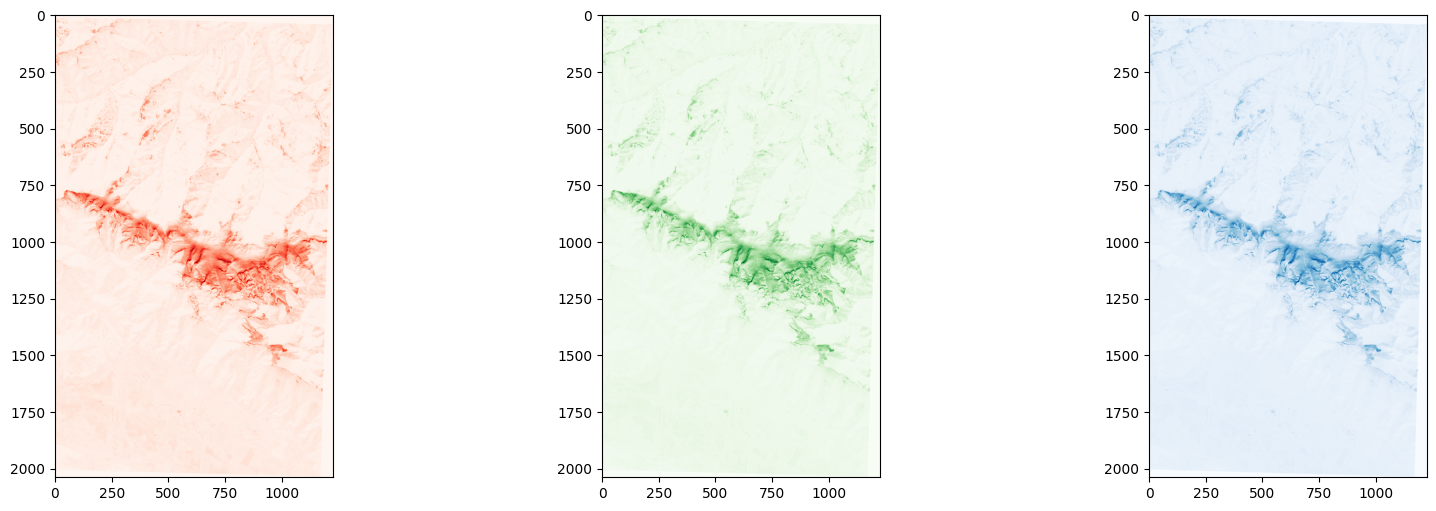

In [12]:
# Visualising RGB image
rgb_image = rio.open(clipped_image, count = 3)
red = rgb_image.read(1)
green = rgb_image.read(2)
blue = rgb_image.read(3)

fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(red, cmap='Reds')
ax1 = fig.add_subplot(1,3,2)
ax1.imshow(green, cmap='Greens')
ax1 = fig.add_subplot(1,3,3)
ax1.imshow(blue, cmap='Blues')

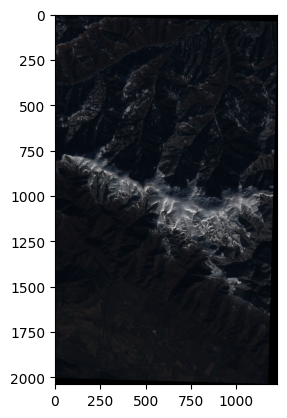

In [13]:
# Normalise function
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

red_n = normalize(red)
green_n = normalize(green)
blue_n = normalize(blue)

# Stack and plot
rgb_composite_n= np.dstack((red_n, green_n, blue_n))
plt.imshow(rgb_composite_n)

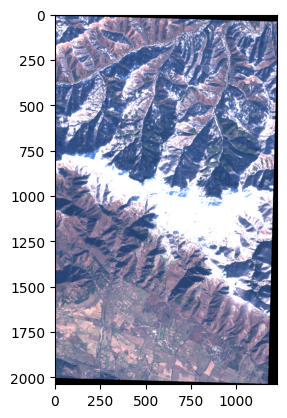

In [14]:
# Brighten the image
def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0,255)

red_b=brighten(red)
blue_b=brighten(blue)
green_b=brighten(green)

red_bn = normalize(red_b)
green_bn = normalize(green_b)
blue_bn = normalize(blue_b)

rgb_composite_bn= np.dstack((red_bn, green_bn, blue_bn))
plt.imshow(rgb_composite_bn)

In [15]:
# Thumbnail and Overview image
from opencosmos.copernicus import sentinel_image_webp
png_path = "data/processed/Sentinel2_visual_processed.png"
rgb_plot=plt.imshow(rgb_composite_bn, interpolation='lanczos')
plt.axis('off')
plt.savefig(png_path,dpi=200,bbox_inches='tight')
plt.close('all')
logging.info(f"PNG file has been saved here:{png_path}")

sentinel = sentinel_image_webp(log=logging)
sentinel.png_to_webp(png_file=png_path)

2023-11-22 22:23:35 - root - INFO - PNG file has been saved here:data/processed/Sentinel2_visual_processed.png
2023-11-22 22:23:35 - root - INFO - Size of the PNG file: 0.73 MB
2023-11-22 22:23:35 - root - INFO - PNG File shape: (484, 779)
2023-11-22 22:23:35 - root - INFO - File size of the converted webp format: 0.04 MB
2023-11-22 22:23:35 - root - INFO - WEBP File shape: (500, 500)
2023-11-22 22:23:35 - root - INFO - Find the converted file here: data/processed/Sentinel2_visual_processed.webp
